# Bayesian Linear Regression
Based on the Seoul Bike Sharing Demand dataset located at ../data/SeoulBikeData.csv
Load the data and split into train and test sets, 80% for training and 20% for testing.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pymc as pm
import arviz as az

Data Preprocessing, make sure to convert the categorical variables into numeric variables.

In [3]:
file_path = '../data/SeoulBikeData.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')
numeric_season = {'Spring' : 1, 'Summer' : 2, 'Autumn' : 3, 'Winter' : 4}
numeric_holiday = {'No Holiday' : 0, 'Holiday' : 1}
numeric_functioning_day = {'No' : 0, 'Yes' : 1}
df['Seasons'] = df['Seasons'].map(numeric_season)
df['Holiday'] = df['Holiday'].map(numeric_holiday)
df['Functioning Day'] = df['Functioning Day'].map(numeric_functioning_day)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['DayOfWeek'] = df['Date'].dt.dayofweek
# df['Month'] = df['Date'].dt.month
# df['Year'] = df['Date'].dt.year
df.drop('Date', axis=1, inplace=True)

print(df.head())
X = df.drop(['Rented Bike Count'], axis=1)
y = df['Rented Bike Count']
print(df.shape)
print(X.shape)
print(y.shape)
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0                254     0             -5.2           37               2.2   
1                204     1             -5.5           38               0.8   
2                173     2             -6.0           39               1.0   
3                107     3             -6.2           40               0.9   
4                 78     4             -6.0           36               2.3   

   Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   
2              2000                      -17.7                      0.0   
3              2000                      -17.6                      0.0   
4              2000                      -18.6                      0.0   

   Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  Functioning Day  DayOfWeek  
0

In [4]:
# scale the data
scaler = StandardScaler()
columns_to_scale = X.columns.difference(['Seasons', 'Holiday', 'Functioning Day', 'DayOfWeek'])
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

print(X_train.isnull().any())
print('-------------------')
print(X_test.isnull().any())


Hour                         False
Temperature(°C)              False
Humidity(%)                  False
Wind speed (m/s)             False
Visibility (10m)             False
Dew point temperature(°C)    False
Solar Radiation (MJ/m2)      False
Rainfall(mm)                 False
Snowfall (cm)                False
Seasons                      False
Holiday                      False
Functioning Day              False
DayOfWeek                    False
dtype: bool
-------------------
Hour                         False
Temperature(°C)              False
Humidity(%)                  False
Wind speed (m/s)             False
Visibility (10m)             False
Dew point temperature(°C)    False
Solar Radiation (MJ/m2)      False
Rainfall(mm)                 False
Snowfall (cm)                False
Seasons                      False
Holiday                      False
Functioning Day              False
DayOfWeek                    False
dtype: bool


In [5]:
X_train_np = X_train.to_numpy(dtype=np.float32)
X_test_np = X_test.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.float32)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print(X_train.head())
print(X_train.describe())

Training set size: (7008, 13)
Test set size: (1752, 13)
          Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
8415  0.505421         0.022370     0.137012          2.092940   
5049 -0.363566         0.838222     1.359982         -0.029683   
8395  1.084745        -0.145847    -0.596770         -0.319131   
1535  1.664070        -1.306543     0.528362          0.259766   
5518  1.519239         1.199888     0.724038         -0.222648   

      Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
8415         -1.176113                   0.130553                 0.519701   
5049         -1.472667                   1.255469                 0.210677   
8395         -0.930350                  -0.316331                -0.659168   
1535         -0.004643                  -0.894198                -0.659168   
5518         -0.707525                   1.371043                -0.659168   

      Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  Functioning Day  \
8415  

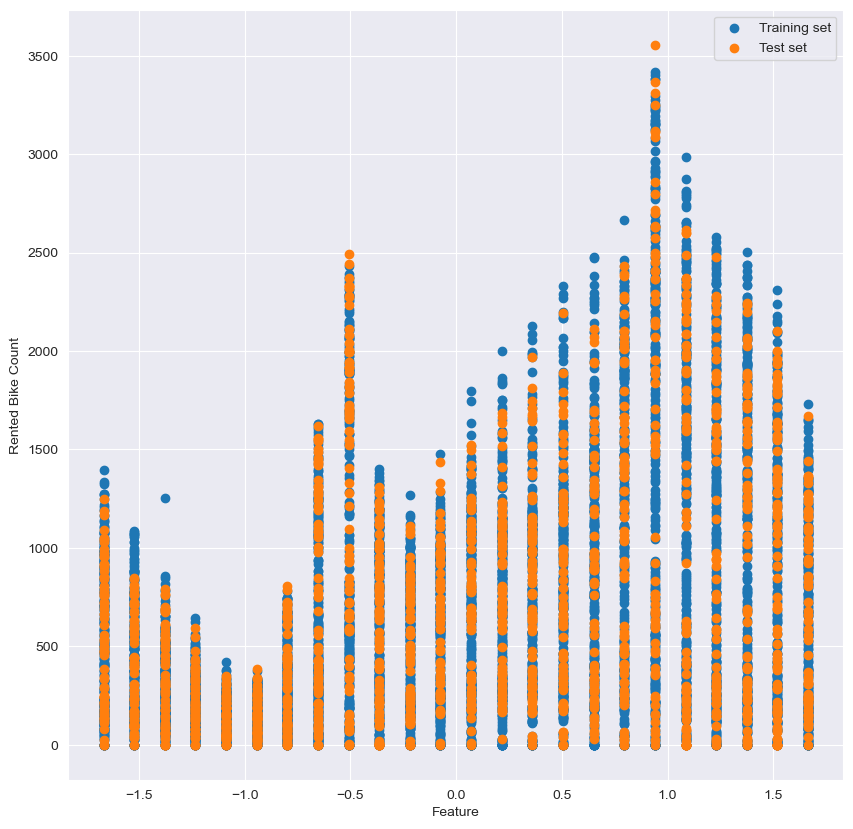

In [70]:
# plot the data
plt.figure(figsize=(10, 10))
plt.scatter(X_train_np[:, 0], y_train_np, label='Training set')
plt.scatter(X_test_np[:, 0], y_test_np, label='Test set')
plt.xlabel('Feature')
plt.ylabel('Rented Bike Count')
plt.legend()
plt.show()

#### Bayesian Linear Regression
Use PyMC to perform Bayesian Linear Regression on your new dataset. 

In [19]:
with pm.Model() as model:

    w0 = pm.Normal('w0', mu=0, sigma=20)

    ws = pm.Normal('ws', mu=0, sigma=20, shape=X_train.shape[1])

    y_est = w0 + pm.math.dot(X_train, ws)

    sigma = pm.Uniform('sigma', lower=0, upper=20)
    likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y_train)

    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w0, ws, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


Sampling: [y]


<Figure size 1000x600 with 0 Axes>

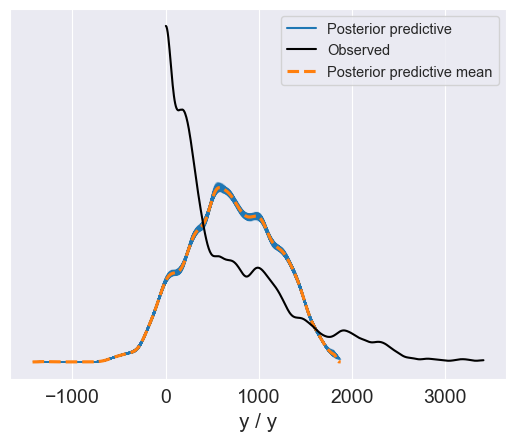

In [20]:
with model:
    y_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

plt.figure(figsize=(10, 6))
az.plot_ppc(y_pred)
plt.show()

In [71]:
with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    betas = pm.Normal('beta', mu=0, sigma=10, shape=X_train_np.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Expected value of outcome
    mu = alpha + pm.math.dot(X_train_np, betas)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_train_np)

    # Inference
    trace = pm.sample(1000, tune=500, cores=2)  # Adjust the number of cores based on your machine

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Posterior Predictive Check, plot the posterior predictive distribution of the model

<Figure size 1000x1000 with 0 Axes>

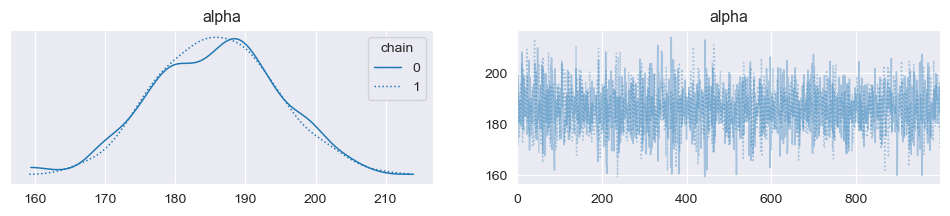

<Figure size 1000x1000 with 0 Axes>

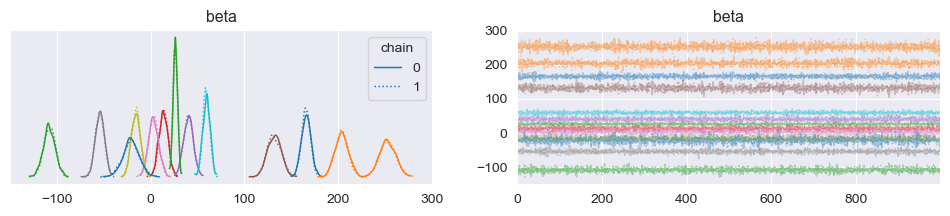

<Figure size 1000x1000 with 0 Axes>

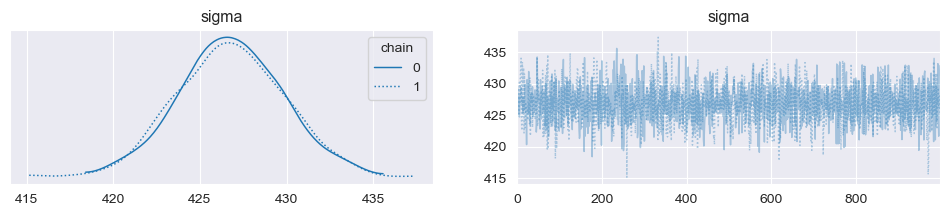

In [72]:
plt.figure(figsize=(10, 10))
az.plot_trace(trace, combined=False, var_names=['alpha'], legend=True)
plt.show()
plt.figure(figsize=(10, 10))
az.plot_trace(trace, combined=False, var_names=['beta'], legend=True)
plt.show()
plt.figure(figsize=(10, 10))
az.plot_trace(trace, combined=False, var_names=['sigma'], legend=True)
plt.show()

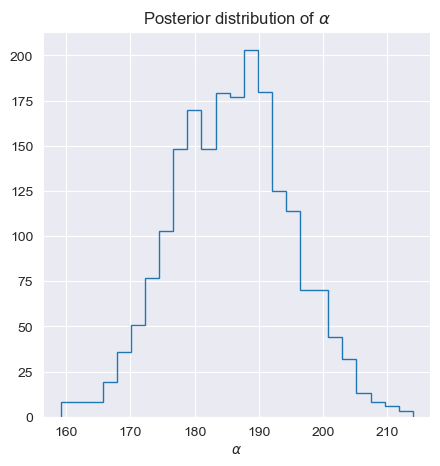

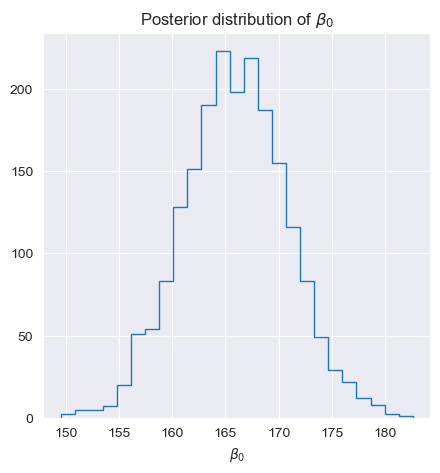

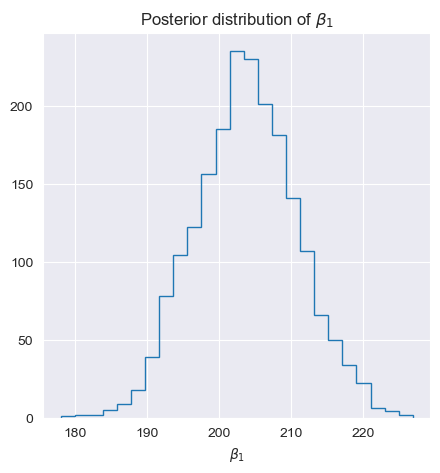

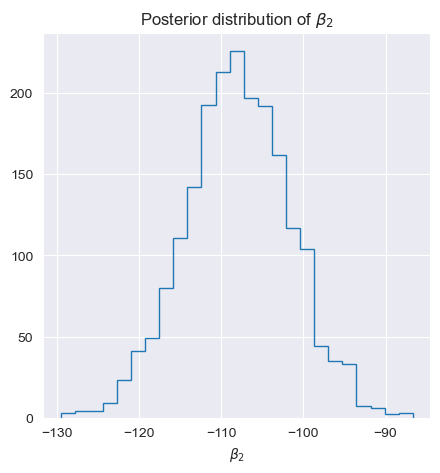

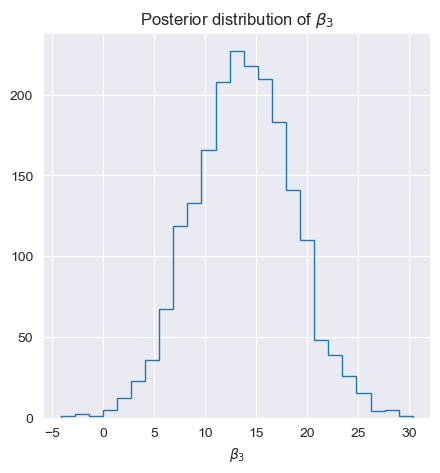

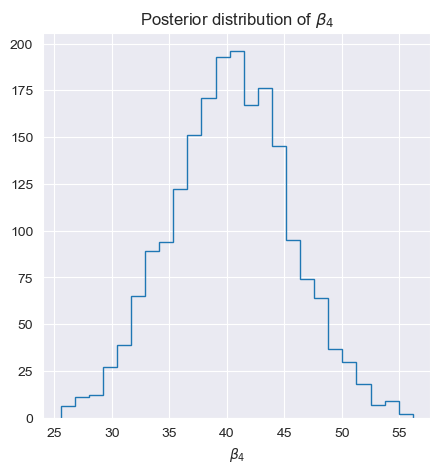

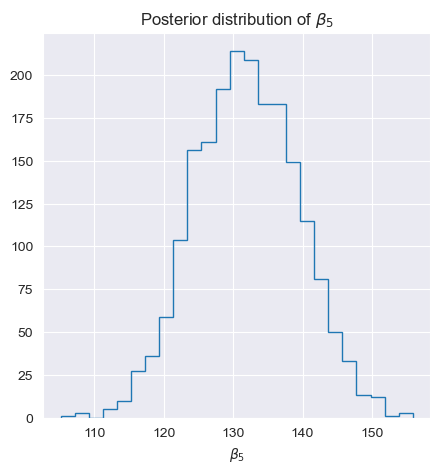

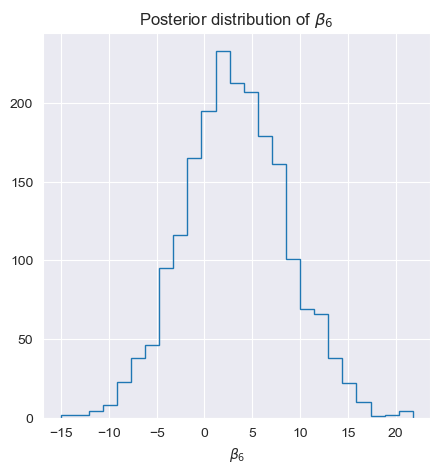

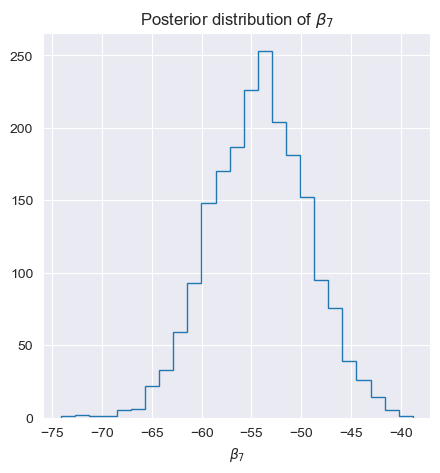

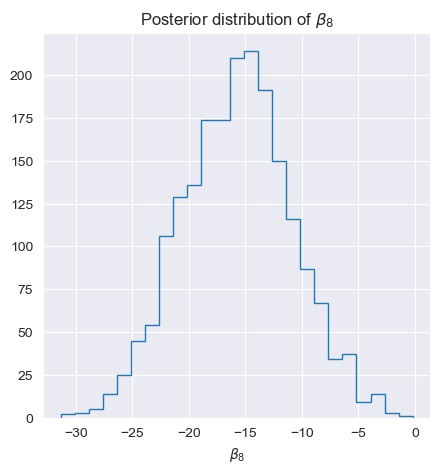

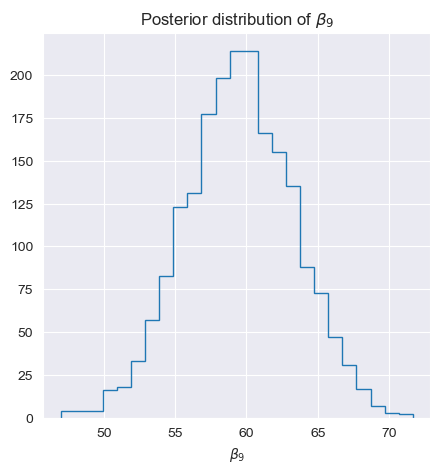

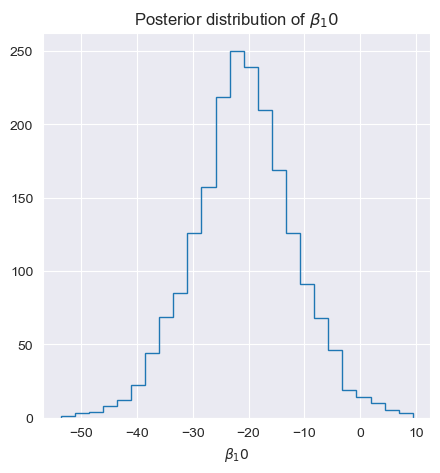

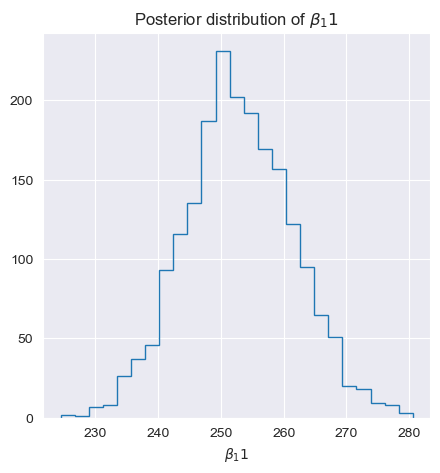

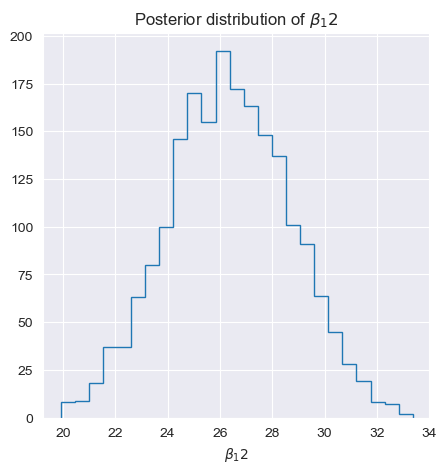

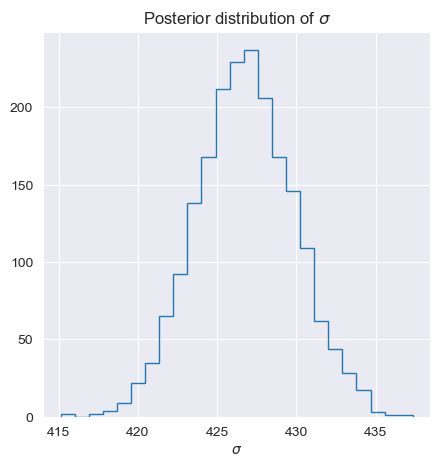

In [73]:
# plot the posterior distributions
plt.figure(figsize=(5, 5))
plt.hist(trace.posterior['alpha'].values.flatten(), bins=25, histtype='step')
plt.xlabel('$\\alpha$')
plt.title('Posterior distribution of $\\alpha$')
plt.show()

# for betas in the model 
for i in range(trace.posterior['beta'].shape[-1]):
    plt.figure(figsize=(5, 5))
    plt.hist(trace.posterior['beta'].sel(beta_dim_0=i).values.flatten(), bins=25, histtype='step')
    plt.xlabel(f'$\\beta_{i}$')
    plt.title(f'Posterior distribution of $\\beta_{i}$')
    plt.show()


plt.figure(figsize=(5, 5))
plt.hist(trace.posterior['sigma'].values.flatten(), bins=25, histtype='step')
plt.xlabel('$\\sigma$')
plt.title('Posterior distribution of $\\sigma$')
plt.show()


Summery posterior mean value for each model parameter generated by arviz.summary

In [74]:
# print the summary of the posterior distribution
summary = az.summary(trace)
print(summary)

             mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha     185.900  9.097  168.377  202.189      0.159    0.113    3250.0   
beta[0]   165.930  4.861  156.680  174.867      0.085    0.060    3271.0   
beta[1]   203.868  7.073  190.049  216.478      0.152    0.108    2161.0   
beta[2]  -107.983  6.336 -120.441  -96.206      0.112    0.080    3185.0   
beta[3]    13.775  4.835    4.759   22.904      0.081    0.060    3577.0   
beta[4]    40.334  5.179   30.708   50.294      0.089    0.063    3376.0   
beta[5]   131.968  7.402  118.804  146.259      0.156    0.111    2253.0   
beta[6]     3.255  5.355   -7.370   13.006      0.101    0.096    2819.0   
beta[7]   -54.156  4.844  -63.053  -45.060      0.080    0.057    3760.0   
beta[8]   -15.707  4.823  -24.909   -6.765      0.081    0.058    3552.0   
beta[9]    59.526  3.816   52.633   66.810      0.069    0.049    3104.0   
beta[10]  -20.765  9.013  -37.642   -3.531      0.162    0.129    3119.0   
beta[11]  25

Sampling: [Y_obs]


<Figure size 1000x600 with 0 Axes>

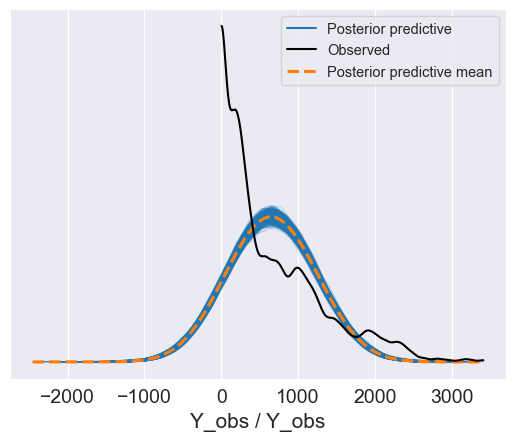

In [75]:
with model:
    y_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

plt.figure(figsize=(10, 6))
az.plot_ppc(y_pred)
plt.show()

#### Bayesian Linear Regression with Log Transformation
The previous model is not performing well, try to improve the model by log transforming the target variable.

In [6]:
y_train_log = np.log(y_train + 1)  # Add 1 to avoid log(0)

num_samples = 1000

with pm.Model() as model:
    n_features = X_train.shape[1]  # Number of features in X_train

    # Adjusted priors for the regression coefficients based on standardized features
    beta = pm.Normal('beta', mu=0, sigma=1, shape=n_features)
    alpha = pm.Normal('alpha', mu=0, sigma=0.5)  # Assuming the mean of y_train_log is around 0 after log transformation
    sigma = pm.Exponential('sigma', 1)

    # Expected value of outcome (in log scale)
    mu_log = alpha + pm.math.dot(X_train, beta)

    # Model the outcome variable in log scale
    Y_obs_log = pm.Normal('Y_obs_log', mu=mu_log, sigma=sigma, observed=y_train_log)

    # Sample from the posterior
    trace = pm.sample(num_samples, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


<Figure size 1000x1000 with 0 Axes>

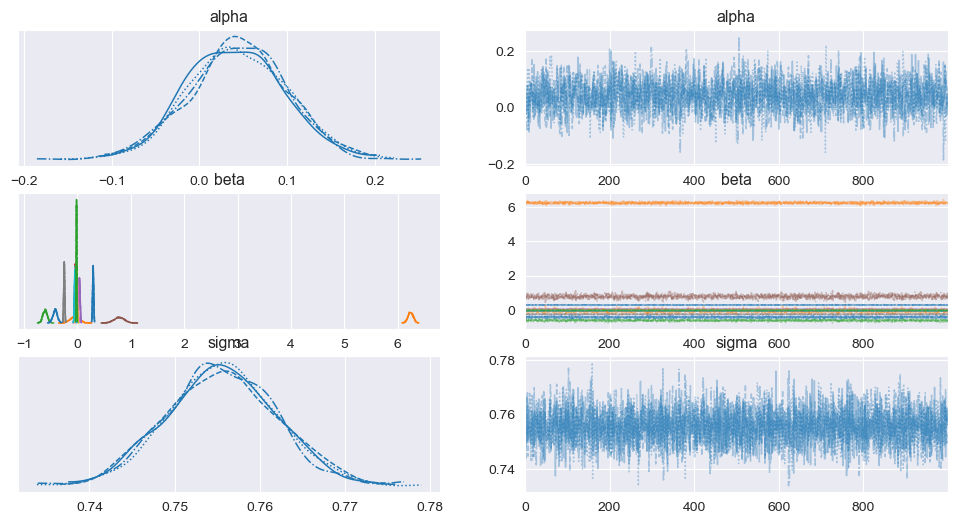

In [15]:
plt.figure(figsize=(10, 10))
az.plot_trace(trace, combined=False, var_names=['alpha', 'beta', 'sigma'])
plt.show()

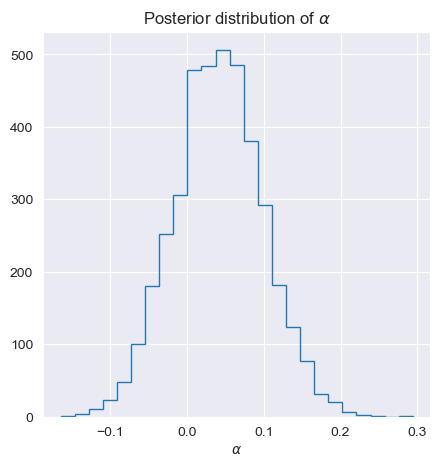

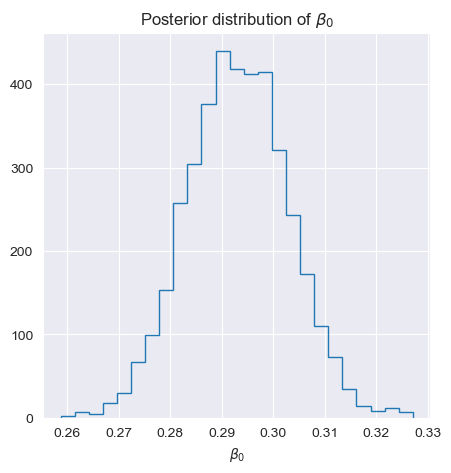

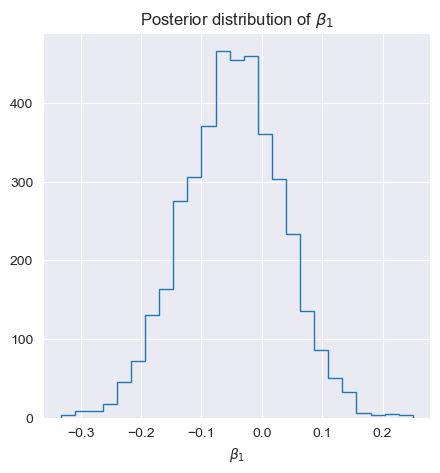

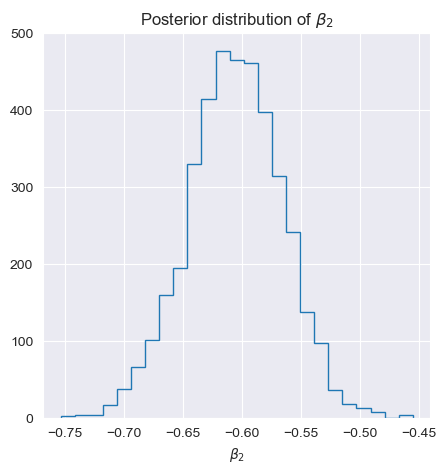

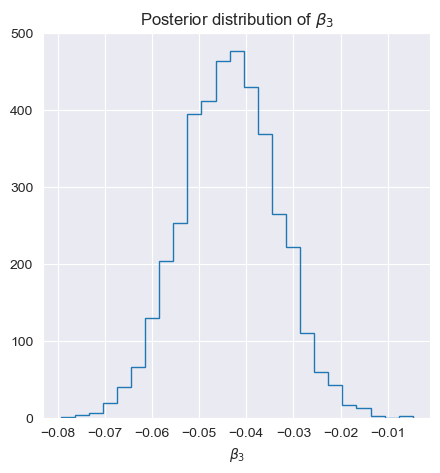

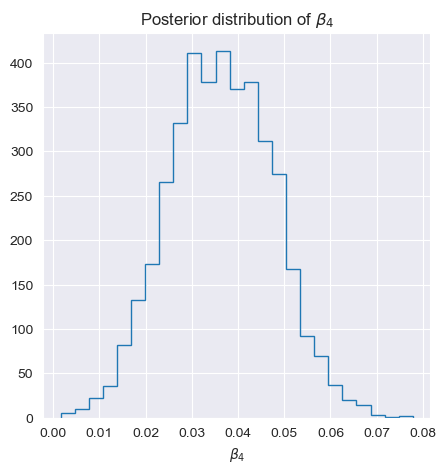

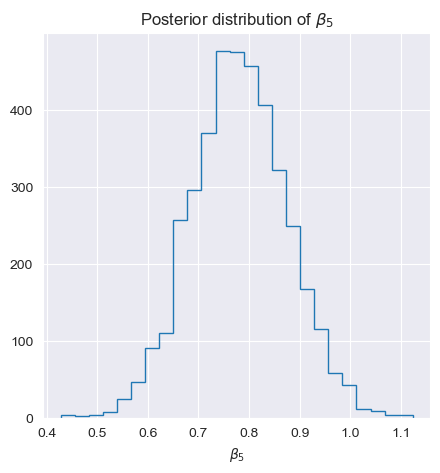

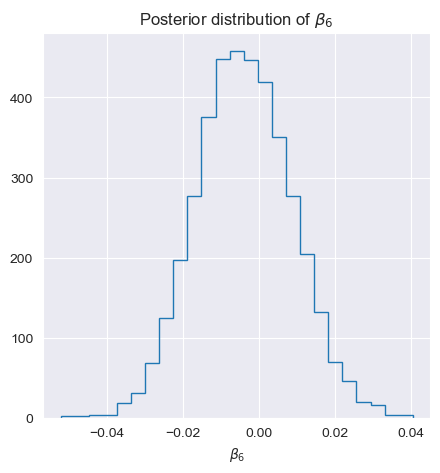

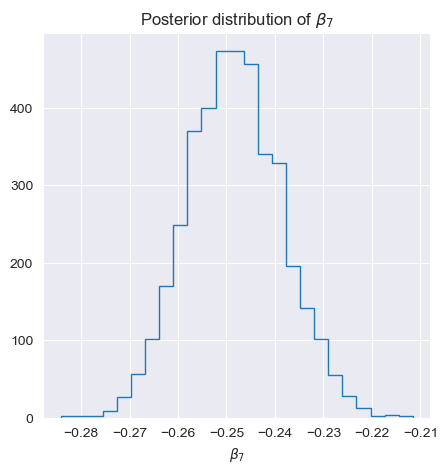

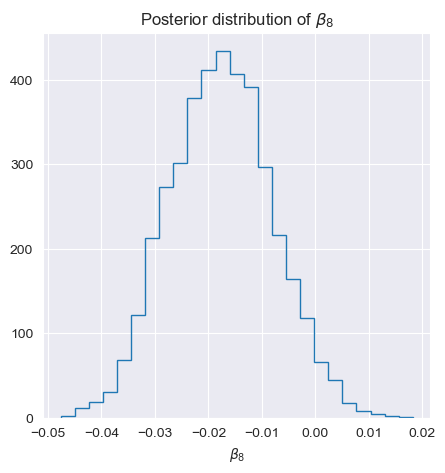

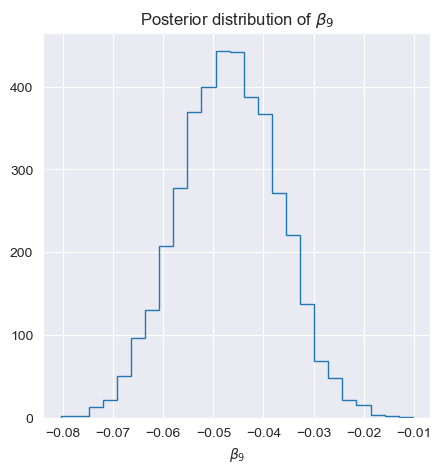

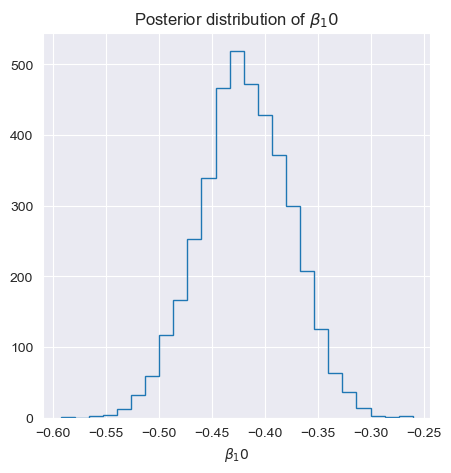

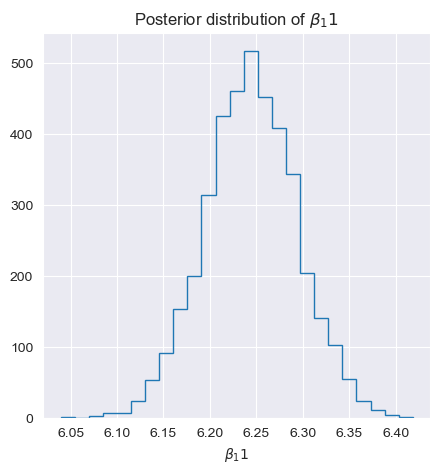

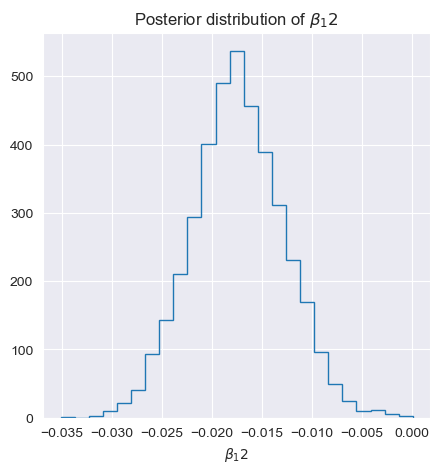

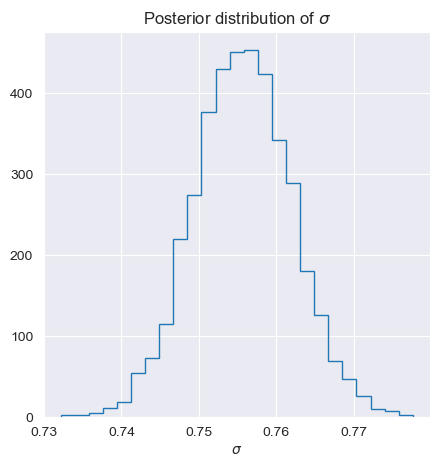

In [78]:
# plot the posterior distributions
plt.figure(figsize=(5, 5))
plt.hist(trace.posterior['alpha'].values.flatten(), bins=25, histtype='step')
plt.xlabel('$\\alpha$')
plt.title('Posterior distribution of $\\alpha$')
plt.show()

# for 13 betas in the model 
for i in range(trace.posterior['beta'].shape[-1]):
    plt.figure(figsize=(5, 5))
    plt.hist(trace.posterior['beta'].sel(beta_dim_0=i).values.flatten(), bins=25, histtype='step')
    plt.xlabel(f'$\\beta_{i}$')
    plt.title(f'Posterior distribution of $\\beta_{i}$')
    plt.show()


plt.figure(figsize=(5, 5))
plt.hist(trace.posterior['sigma'].values.flatten(), bins=25, histtype='step')
plt.xlabel('$\\sigma$')
plt.title('Posterior distribution of $\\sigma$')
plt.show()

In [18]:
# print the summary of the posterior distribution
summary = az.summary(trace)
print(summary)

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   0.293  0.010   0.275    0.312      0.000    0.000    4286.0   
beta[1]  -0.049  0.085  -0.215    0.101      0.002    0.002    1515.0   
beta[2]  -0.607  0.042  -0.683   -0.527      0.001    0.001    1572.0   
beta[3]  -0.044  0.010  -0.064   -0.025      0.000    0.000    4352.0   
beta[4]   0.036  0.012   0.015    0.059      0.000    0.000    4443.0   
beta[5]   0.784  0.098   0.602    0.963      0.003    0.002    1524.0   
beta[6]  -0.004  0.013  -0.028    0.021      0.000    0.000    3456.0   
beta[7]  -0.248  0.009  -0.266   -0.230      0.000    0.000    4470.0   
beta[8]  -0.017  0.010  -0.035    0.001      0.000    0.000    4386.0   
beta[9]  -0.047  0.010  -0.065   -0.028      0.000    0.000    4329.0   
beta[10] -0.418  0.042  -0.497   -0.336      0.001    0.000    4483.0   
beta[11]  6.243  0.049   6.149    6.330      0.001    0.001    2681.0   
beta[12] -0.018  0.004  -0.026   -0.009      0.000 

Sampling: [Y_obs_log]


<Figure size 1000x600 with 0 Axes>

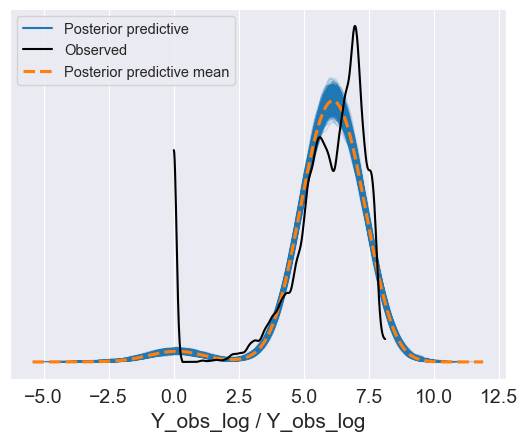

In [80]:
with model:
    y_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

plt.figure(figsize=(10, 6))
az.plot_ppc(y_pred)
plt.show()

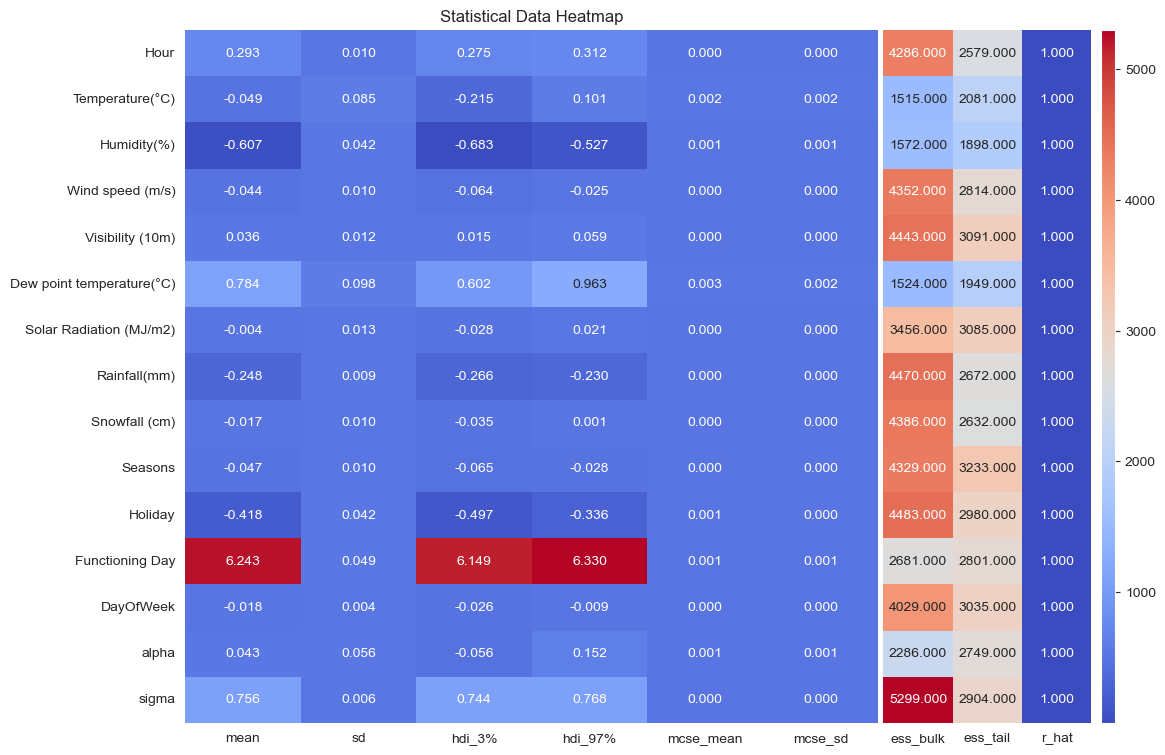

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from io import BytesIO
import seaborn as sns

feature_names = X_train.columns.tolist()
data = {
    'mean': [0.293, -0.049, -0.607, -0.044, 0.036, 0.784, -0.004, -0.248, -0.017, -0.047, -0.418, 6.243, -0.018, 0.043, 0.756],
    'sd': [0.010, 0.085, 0.042, 0.010, 0.012, 0.098, 0.013, 0.009, 0.010, 0.010, 0.042, 0.049, 0.004, 0.056, 0.006],
    'hdi_3%': [0.275, -0.215, -0.683, -0.064, 0.015, 0.602, -0.028, -0.266, -0.035, -0.065, -0.497, 6.149, -0.026, -0.056, 0.744],
    'hdi_97%': [0.312, 0.101, -0.527, -0.025, 0.059, 0.963, 0.021, -0.230, 0.001, -0.028, -0.336, 6.330, -0.009, 0.152, 0.768],
    'mcse_mean': [0.000, 0.002, 0.001, 0.000, 0.000, 0.003, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.000, 0.001, 0.000],
    'mcse_sd': [0.000, 0.002, 0.001, 0.000, 0.000, 0.002, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.001, 0.000],
    'ess_bulk': [4286.0, 1515.0, 1572.0, 4352.0, 4443.0, 1524.0, 3456.0, 4470.0, 4386.0, 4329.0, 4483.0, 2681.0, 4029.0, 2286.0, 5299.0],
    'ess_tail': [2579.0, 2081.0, 1898.0, 2814.0, 3091.0, 1949.0, 3085.0, 2672.0, 2632.0, 3233.0, 2980.0, 2801.0, 3035.0, 2749.0, 2904.0],
    'r_hat': [1.0] * 15
}

df = pd.DataFrame(data)
df.index = feature_names + ['alpha', 'sigma']
fig, ax = plt.subplots(figsize=(12, 9))

divider = make_axes_locatable(ax)

left_size = 6 / (6 + 3 + 1)  
right_size = 3 / (6 + 3 + 1)

cax = divider.append_axes("right", size=f"{right_size * 100}%", pad=0.05)
sns.heatmap(df.iloc[:, :6], ax=ax, cbar=False, annot=True, fmt=".3f", cmap="coolwarm")
heatmap = sns.heatmap(df.iloc[:, 6:], ax=cax, cbar=False, annot=True, fmt=".3f", cmap="coolwarm")

cax.yaxis.set_visible(False)
cbar_ax = divider.append_axes("right", size="2%", pad=0.1)
plt.colorbar(heatmap.collections[0], cax=cbar_ax, orientation='vertical')
ax.set_title('Statistical Data Heatmap')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

img_buf = BytesIO()
plt.savefig(img_buf, format='png', bbox_inches='tight')
img_buf.seek(0)
plt.show()
img_buf